In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
t0 = 1649730445 # April 10, 2022, 2:27:25 GMT
N = 1000
T = np.random.uniform(t0, t0 + 365*24*3600, N)
Tday = T % (24*3600)
Tsin = np.sin(2*np.pi*Tday / (24*3600))
Tcos = np.cos(2*np.pi*Tday / (24*3600))

X = 0.5*Tsin + 6.2*Tcos
X += np.random.normal(0, 0.1, N)
X -= -2 + np.min(X)

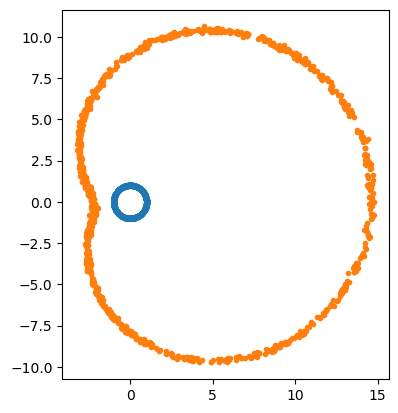

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(Tcos, Tsin, ".")
ax.plot(X*Tcos, X*Tsin, ".")
ax.set_aspect("equal")

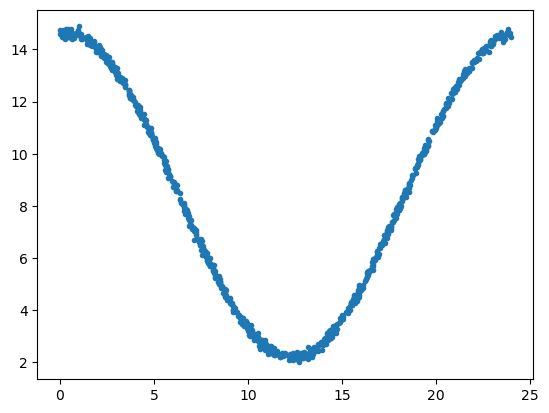

In [75]:
plt.plot(Tday/3600, X, ".")